In [1]:
!pip install natsort

In [2]:
import glob
from natsort import natsorted

import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt

from leopard_em.analysis.zscore_metric import gaussian_noise_zscore_cutoff

In [3]:
plt.rcParams.update(
    {
        "font.size": 7,
        "axes.labelsize": 7,
        "axes.titlesize": 9,
        "xtick.labelsize": 7,
        "ytick.labelsize": 7,
        "axes.edgecolor": (0, 0, 0, 0.6),
        "xtick.color": (0, 0, 0, 0.6),
        "ytick.color": (0, 0, 0, 0.6),
        "axes.labelcolor": (0, 0, 0, 0.6),
    }
)

## Constants used throughout notebook

In [4]:
MATCH_TEMPLATE_DIR_REFERENCE = "/data/papers/Leopard-EM_paper_data/xe30kv/results_refine_tm_60S_new_2"
MATCH_TEMPLATE_DIR_CONSTRAINED = "/data/papers/Leopard-EM_paper_data/xe30kv/results_refine_tm_40S-body_new_2"
CONSTRAINED_SEARCH_DIR = "/data/papers/Leopard-EM_paper_data/xe30kv/results_all_steps_new_2/final_results/"
OUTPUT_DIR = "."

## Collecting results into unified DataFrame

In [5]:
# All results CSV files from the reference match template directory
refined_results_reference = glob.glob(f"{MATCH_TEMPLATE_DIR_REFERENCE}/*refined_results.csv")
refined_results_reference_sorted = natsorted(refined_results_reference)

# All results CSV files from the constrained particle match template directory
refined_results_constrained = glob.glob(f"{MATCH_TEMPLATE_DIR_CONSTRAINED}/*refined_results.csv")
refined_results_constrained_sorted = natsorted(refined_results_constrained)

# All results CSV files from the constrained search directory
constrained_results = glob.glob(f"{CONSTRAINED_SEARCH_DIR}/*results_above_threshold.csv")
constrained_results_sorted = natsorted(constrained_results)

In [6]:
exclude_filters = [
    "227",
    "237",
    "239",
    "245",
    "249",
    "254",
    "255",
    "260",
    "264",
    "265",
    "266",
    "267",
    "268",
    "270",
    "271",
    "283",
    "284",
    "285",
    "286",
    "287",
    "288",
    "289",
    "290",
    "291"
]

# Filter the 2dtm results
refined_results_reference_filtered = [f for f in refined_results_reference_sorted if not any(exclude in f for exclude in exclude_filters)]
refined_results_constrained_filtered = [f for f in refined_results_constrained_sorted if not any(exclude in f for exclude in exclude_filters)]
constrained_results_filtered = [f for f in constrained_results_sorted if not any(exclude in f for exclude in exclude_filters)]

In [7]:
def collect_results_files(
    reference_match_template_files: list[str],
    constrained_match_template_files: list[str],
    constrained_search_files: list[str],
) -> list[tuple[str, str, str]]:
    """Collect the files from the same original dataset together based on name."""
    # NOTE: This assumes naming schemes and file structure are consistent.
    collected_results = []

    # Look for matches based on the reference match template files
    for ref_mt in reference_match_template_files:
        base_name = ref_mt.split("/")[-1].replace("_refined_results.csv", "")

        # Find constrained files which also contain this string
        const_mt = [c for c in constrained_match_template_files if base_name in c]
        const_search = [c for c in constrained_search_files if base_name in c]

        # Check that there is exactly one match for each
        if len(const_mt) == 1 and len(const_search) == 1:
            collected_results.append((ref_mt, const_mt[0], const_search[0]))
        else:
            raise ValueError(
                f"Expected exactly one match for {base_name}, "
                f"found {len(const_mt)} constrained match templates and "
                f"{len(const_search)} constrained search files."
            )

    return collected_results


collected_results = collect_results_files(
    refined_results_reference_filtered,
    refined_results_constrained_filtered,
    constrained_results_filtered,
)

In [8]:
def process_all_results(collected_results: list[tuple[str, str, str]]) -> None:
    """Process all collected results and save the processed data."""
    df_reference = pd.DataFrame()
    df_constrained_mt = pd.DataFrame()
    df_constrained_search = pd.DataFrame()

    for ref_file, const_mt_file, const_search_file in collected_results:
        # Read the CSV files
        df_ref = pd.read_csv(ref_file)
        df_const_mt = pd.read_csv(const_mt_file)
        df_const_search = pd.read_csv(const_search_file)

        # Append to the main dataframes
        df_reference = pd.concat([df_reference, df_ref], ignore_index=True)
        df_constrained_mt = pd.concat(
            [df_constrained_mt, df_const_mt], ignore_index=True
        )
        df_constrained_search = pd.concat(
            [df_constrained_search, df_const_search], ignore_index=True
        )
        
    return df_reference, df_constrained_mt, df_constrained_search

df_reference, df_constrained_mt, df_constrained_search = process_all_results(collected_results)

In [9]:
df_reference.head()

,Unnamed: 0,particle_index,mip,scaled_mip,refined_mip,refined_scaled_mip,correlation_mean,correlation_variance,total_correlations,pos_x,...,micrograph_path,template_path,mip_path,scaled_mip_path,psi_path,theta_path,phi_path,defocus_path,correlation_average_path,correlation_variance_path
0,0,0,14.440077,15.026255,16.195541,16.530300,-0.020782,0.962373,20598240,2176,...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/ma...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...
1,1,1,14.796845,14.546139,16.098782,15.917622,0.112327,1.009513,20598240,2389,...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/ma...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...
2,2,2,14.869853,14.461102,15.787861,15.555633,0.029651,1.026215,20598240,1147,...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/ma...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...
3,3,3,14.757597,14.436035,16.573242,16.349610,0.096907,1.015562,20598240,2743,...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/ma...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...
4,4,4,14.755838,14.432348,15.491174,15.299728,0.044024,1.019364,20598240,806,...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/ma...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...


In [10]:
df_constrained_mt.head()

,Unnamed: 0,particle_index,mip,scaled_mip,refined_mip,refined_scaled_mip,correlation_mean,correlation_variance,total_correlations,pos_x,...,micrograph_path,template_path,mip_path,scaled_mip_path,psi_path,theta_path,phi_path,defocus_path,correlation_average_path,correlation_variance_path
0,0,0,9.708725,9.423812,10.237336,10.003329,0.176780,1.011475,20598240,1177,...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/ma...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...
1,1,1,9.298006,8.956709,10.534189,10.307774,0.070585,1.030224,20598240,3205,...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/ma...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...
2,2,2,8.966356,8.849005,9.411008,9.316052,0.070133,1.005336,20598240,2403,...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/ma...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...
3,3,3,9.278904,8.767706,10.533393,10.204960,0.082310,1.048917,20598240,3326,...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/ma...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...
4,4,4,8.846063,8.758075,8.978577,8.895184,0.078654,1.001066,20598240,2756,...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/ma...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...


In [11]:
df_constrained_search.head()

,Unnamed: 0,particle_index,mip,scaled_mip,refined_mip,refined_scaled_mip,correlation_mean,correlation_variance,total_correlations,pos_x,...,template_path,mip_path,scaled_mip_path,psi_path,theta_path,phi_path,defocus_path,correlation_average_path,correlation_variance_path,step
0,0,0,14.440077,15.026255,9.563240,9.789586,-0.020782,0.962373,20598240,2176,...,/home/data/jdickerson/Leopard-EM_paper_data/ma...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,4
1,1,1,14.796845,14.546139,5.918373,5.774761,0.112327,1.009513,20598240,2389,...,/home/data/jdickerson/Leopard-EM_paper_data/ma...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,4
2,2,2,14.869853,14.461102,4.844554,4.718485,0.029651,1.026215,20598240,1147,...,/home/data/jdickerson/Leopard-EM_paper_data/ma...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,2
3,3,3,14.757597,14.436035,6.487387,6.274565,0.096907,1.015562,20598240,2743,...,/home/data/jdickerson/Leopard-EM_paper_data/ma...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,4
4,5,5,14.721283,14.261932,7.817905,7.561977,0.088336,1.026014,20598240,2859,...,/home/data/jdickerson/Leopard-EM_paper_data/ma...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,/home/data/jdickerson/Leopard-EM_paper_data/xe...,4


In [12]:
df_constrained_search["original_offset_psi"]

0        1.3
1       -7.9
2       -4.0
3       -4.5
4      -10.7
        ... 
7873    -0.1
7874    -1.9
7875     1.5
7876     0.1
7877    -0.1
Name: original_offset_psi, Length: 7878, dtype: float64

## 1D histogram plots for Theta and Psi offsets

In [13]:
bins = np.arange(-15.5, 5.5, 1)
bins

array([-15.5, -14.5, -13.5, -12.5, -11.5, -10.5,  -9.5,  -8.5,  -7.5,
        -6.5,  -5.5,  -4.5,  -3.5,  -2.5,  -1.5,  -0.5,   0.5,   1.5,
         2.5,   3.5,   4.5])

In [14]:
90/25.4, 60/25.4

(3.5433070866141736, 2.362204724409449)

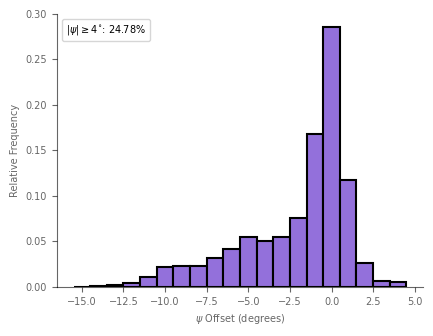

In [15]:
# pct_psi_ge_4 = (
#     np.sqrt(
#         df_constrained_search["original_offset_psi"] ** 2
#         + df_constrained_search["original_offset_theta"] ** 2
#     )
#     >= 4
# )
pct_psi_ge_4 = df_constrained_search["original_offset_psi"].abs() >= 4
pct_psi_ge_4 = pct_psi_ge_4.mean() * 100

fig, ax = plt.subplots(figsize=(120 / 25.4, 90 / 25.4))

plt.hist(
    df_constrained_search["original_offset_psi"],
    bins=bins,
    density=True,
    color="#9370DB",
    edgecolor="black",
    linewidth=1.5,
)
plt.plot(
    [], [], " ", label=rf"$\vert \psi \vert \geq 4^{{\circ}}$: {pct_psi_ge_4:.2f}%"
)
plt.xlabel(r"$\psi$ Offset (degrees)")
plt.ylabel("Relative Frequency")
plt.ylim(0, 0.30)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.legend(handlelength=0, handletextpad=0, loc="upper left")

plt.savefig(f"{OUTPUT_DIR}/constrained_xe30kv_phi_histogram.png", dpi=300, bbox_inches="tight")
plt.savefig(f"{OUTPUT_DIR}/constrained_xe30kv_phi_histogram.pdf", dpi=300, bbox_inches="tight")
plt.show()

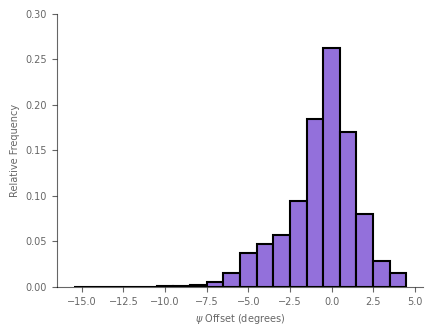

In [16]:
fig, ax = plt.subplots(figsize=(120 / 25.4, 90 / 25.4))

plt.hist(
    df_constrained_search["original_offset_theta"],
    bins=bins,
    density=True,
    color="#9370DB",
    edgecolor="black",
    linewidth=1.5,
)
# plt.plot(
#     [], [], " ", label=rf"$\vert \psi \vert \geq 4^{{\circ}}$: {pct_psi_ge_4:.2f}%"
# )
plt.xlabel(r"$\psi$ Offset (degrees)")
plt.ylabel("Relative Frequency")
plt.ylim(0, 0.30)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# plt.legend(handlelength=0, handletextpad=0, loc="upper left")

plt.savefig(f"{OUTPUT_DIR}/constrained_xe30kv_theta_histogram.png", dpi=300, bbox_inches="tight")
plt.savefig(f"{OUTPUT_DIR}/constrained_xe30kv_theta_histogram.pdf", dpi=300, bbox_inches="tight")
plt.show()

## Contour plot for 2D angular distributions

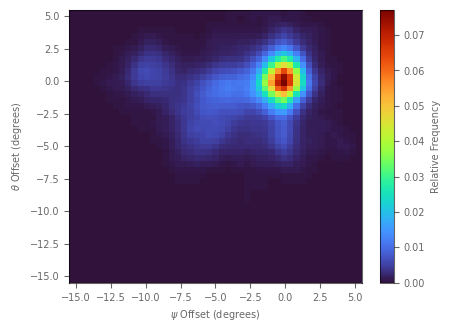

In [ ]:
phi_bins = np.linspace(-15.5, 5.5, num=48)
theta_bins = np.linspace(-15.5, 5.5, num=48)

phi_edges = phi_bins[:-1] + phi_bins[1:] / 2
theta_edges = theta_bins[:-1] + theta_bins[1:] / 2
xx, yy = np.meshgrid(phi_edges, theta_edges)

# 2D histogram for psi and theta offsets onto the grid
hist, xedges, yedges = np.histogram2d(
    df_constrained_search["original_offset_psi"],
    df_constrained_search["original_offset_theta"],
    bins=[phi_bins, theta_bins],
    density=True,
)

# Apply Gaussian smoothing to the histogram
hist = gaussian_filter(hist, sigma=1)

# Create a heatmap of the density
fig, ax = plt.subplots(figsize=(120 / 25.4, 90 / 25.4))

im = ax.imshow(
    hist.T,
    cmap="turbo",
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    origin="lower",
    aspect="auto",
    # interpolation="bilinear",
)
cbar = plt.colorbar(im, ax=ax)


cbar.set_label("Relative Frequency")
plt.xlabel(r"$\psi$ Offset (degrees)")
plt.ylabel(r"$\theta$ Offset (degrees)")

plt.savefig(f"{OUTPUT_DIR}/constrained_xe30kv_2d_heatmap.png", dpi=300, bbox_inches="tight")
plt.savefig(f"{OUTPUT_DIR}/constrained_xe30kv_2d_heatmap.pdf", dpi=300, bbox_inches="tight")
plt.show()